#  Filtering Spam Messages using a Naive Bayes ML algorithm

The goal of this lab is to implement a Naive Bayes Machine learning algorithm with the goal of classifying text as spam or ham (not spam).

The optimization strategy that will be implemented for this algorithm is Maximum Likelihood Estimation (MLE). 

#### Some ressources on Naive Bayes:

https://www.youtube.com/watch?v=sjUDlJfdnKM : naive bayes

https://www.youtube.com/watch?v=5NMxiOGL39M : how bayes theorem works

https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73 : spam classifier in python

https://www.kaggle.com/astandrik/simple-spam-filter-using-naive-bayes

https://www.kaggle.com/afagarap/gaussian-naive-bayes-classifier : gaussian bayes

https://github.com/dannypaz/class/blob/262ae6eba4a97015e154bc9078328684ff8de97e/dsci-6003/deprecated/week1/1.4/DSCI6003-1.4.Lecture.ipynb : naive bayes course + MLE


http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=27993555129092B2B08538AE1F67BDA5?doi=10.1.1.61.5542&rep=rep1&type=pdf : paper, diff naive bayes for spam classification

https://scikit-learn.org/stable/modules/naive_bayes.html#bernoulli-naive-bayes : scikit learn Naive bayes explanation


https://web.stanford.edu/class/cs124/lec/naivebayes.pdf : stanford naive bayes course (good explanation for MLE)

https://blog.metaflow.fr/ml-notes-why-the-log-likelihood-24f7b6c40f83 : article "why use the log-likelyhood"

## Implementation

### 1) Divide the data in two groups: training and test examples.

Importing the necessary libraries for data manipulation

In [1]:
import numpy as np
import pandas as pd
import os #for going in the right directory to gather the data
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter



Looking at the data in the text file we can identyfy its structure. The .txt file contains all of the features + target in plain text (ascii) format.

The data is structured in the following manner:

    - "ham    words in the message \n" target and feature seperated by tab (\t), samples seperated by carriage return \n
    - "spam    words in the message\n"
    
we need to separate the features (text in the message) from the target (if it is a spam or not).

### Reading file and seperating features and target

In [2]:
#file name and location
file_name = "messages.txt"
rel_path = "data/"


data = pd.DataFrame([line.split("\t") for line in open(rel_path+file_name) ],columns = ["target","text"])
print(data.head())

  target                                               text
0    ham                  Yup i've finished c Ã¼ there...\n
1    ham             Remember to ask alex about his pizza\n
2    ham                     No da..today also i forgot..\n
3    ham  Ola would get back to you maybe not today but ...
4    ham  Fwiw the reason I'm only around when it's time...


### Cleaning the data (optional)

Indeed, we can see a lot of characters which should not be in the text data like '\n' and some other special characters whic were not properly decoded.

1) First we remove the "\n" from the text columns

In [3]:
data["text"] = data["text"][:-1] #not working....


print(data.head())

sample = data["text"][0][:-1]
sample

  target                                               text
0    ham                  Yup i've finished c Ã¼ there...\n
1    ham             Remember to ask alex about his pizza\n
2    ham                     No da..today also i forgot..\n
3    ham  Ola would get back to you maybe not today but ...
4    ham  Fwiw the reason I'm only around when it's time...


"Yup i've finished c Ã¼ there..."

2) find the rows with missing data and just enter a random word, this error came up for the very last line which contained the word "ok"

In [4]:
for i,mess in enumerate(data["text"]):
    #print(i)
    if type(mess) == float:
        print(mess)
        data.iloc[i,1] = "Ok"

nan


3) (optional) Remove some common words which dont have any sort of indication wether or not a word could contribute to the message being a spam. Since we consider all these features to be independent from one another, it doesnt matter if we remove words that would take out the 'meaning' of the text message

4) Turning the target from text to a binary (integer) value

In [5]:
data.loc[data.target == "ham", 'y'] = 0
data.loc[data.target == "spam", 'y'] = 1


### Taking a closer look at the data

In [6]:
data.groupby("y").describe()

target                     text         \
     count unique   top  freq count unique   
y                                            
0.0   4328      1   ham  4328  4328   4072   
1.0    672      1  spam   672   672    596   

                                                             
                                                   top freq  
y                                                            
0.0                           Sorry, I'll call later\n   26  
1.0  Please call our customer service representativ...    4

Out of all the 5000 samples in this dataset:
- 87% are not spam
- 13% are spam

object


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A6D0C823C8>,
      dtype=object)

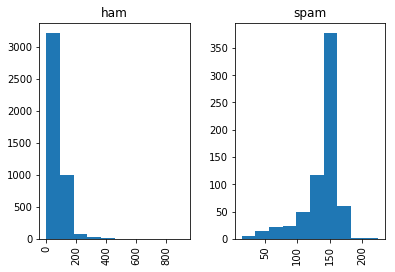

In [7]:
#ploting the length of messages for both spam and ham
data["message_length"] = data["text"].apply(len)

print(data["text"].dtype)

data.hist(by="target",column='message_length') #histograms of the target classes based on the message length

We can also notice that spams tend to have more characters than hams




### Splitting training and test data

Now we can proceed to partition our data into 2 sets: 

- one training set with a majority of the samples (usualy > 60%) that we will use to train our model on

- And a test set with the remaining samples so that we can validate the performance of our model on unseen data samples

In [8]:
X = data["text"]
y = data["y"]

train_size = 0.7 
train_samples = round(X.size * train_size) # 3500 samples (with 0.7)

X_train = X[:train_samples].reset_index(drop=True) # we need to reset the indexes of the data to make it easier to access later
y_train = y[:train_samples].reset_index(drop=True)

print("training samples" ,X_train.size)

X_test = X[train_samples:].reset_index(drop=True)
y_test = y[train_samples:].reset_index(drop=True)


print("testing samples" ,X_test.size)

training samples 3500
testing samples 1500


### A better way to split
Here we are simply taking the first n% and spliting it into two parts. A better way to split would be to "shuffle" the data by picking from a uniform distribution if we get a value over our desired threshold. 

This way is better because there could be some unwanted corelation in the way our data was collected and stored in the file (ex: hams in the begining and spams at the end). This is why shufling the data makes more sense to provide a better statistical distribution. 

In [9]:
threshold = train_size
samples = data["text"].size

train_i = list()
test_i = list()

for index in range(X.size):
    if np.random.uniform(0,1) < threshold:
        train_i += [index]
    else:
        test_i += [index]

X_train_norm =  X.loc[train_i].reset_index(drop=True)
y_train_norm =  y.loc[train_i].reset_index(drop=True)

X_test_norm = X.loc[test_i].reset_index(drop=True)
y_test_norm = y.loc[test_i].reset_index(drop=True)

print(X_test_norm.head())
        

0    Fwiw the reason I'm only around when it's time...
1                                             Yup...\n
2    U wake up already? Wat u doing? U picking us u...
3    Bognor it is! Should be splendid at this time ...
4                             Sorry, I'll call later\n
Name: text, dtype: object


### Dictionary generation

Now that we have cleaned our data, split it into the training and testing groups we can build up our dictionary. This dictionary will contain all of the words that appear in the training set.

The dimension of this dictionary will dictate the dimensions of our feature vector
* We only take the 3000 most common occuring words. 

In [10]:
def create_dict(size,data):
    
    
    all_words = []
    for i,message in data.iteritems():
        words = message.split() #splits line into a list of words
        for word in words:
            if word.isalpha() and len(word) > 1 and word not in stopwords.words('english')  : #check if word is alpha (letters) and more than one character in length
                all_words += [word] 
        
    # now we can count the occurence of each word in the list
    dictionary = Counter(all_words).most_common(size)
    dictionary = [list(word) for word in dictionary] #transforming dictionary into list format
    return dictionary

dictionary = create_dict(500,X_train)
print(dictionary)

[['call', 245], ['get', 209], ['ur', 190], ['You', 156], ['go', 143], ['like', 139], ['know', 129], ['got', 127], ['come', 120], ['time', 104], ['want', 95], ['Call', 95], ['If', 91], ['going', 91], ['How', 89], ['still', 88], ['send', 85], ['need', 85], ['So', 83], ['one', 83], ['text', 81], ['No', 80], ['But', 78], ['We', 78], ['see', 73], ['back', 72], ['home', 71], ['good', 71], ['tell', 70], ['mobile', 70], ['Do', 69], ['Just', 69], ['free', 68], ['Ok', 66], ['My', 65], ['take', 64], ['What', 64], ['love', 63], ['And', 63], ['FREE', 62], ['new', 60], ['think', 60], ['The', 59], ['dont', 59], ['give', 58], ['day', 57], ['Have', 56], ['Your', 56], ['Hey', 56], ['da', 54], ['later', 52], ['great', 52], ['much', 52], ['To', 51], ['make', 51], ['phone', 50], ['Are', 49], ['This', 47], ['reply', 47], ['ask', 46], ['number', 46], ['meet', 46], ['Its', 45], ['claim', 45], ['way', 44], ['Can', 43], ['last', 43], ['right', 43], ['contact', 43], ['gonna', 42], ['really', 42], ['Please', 42],

We chose to take all of the words in lowecase but spams usually contain a lot of uppecase words, so maybe this was not the optimal choice or it might not have any incidence on the results.

## Feature extraction 

Now we extract the features from the text data and generate the proper vectors based on our dictionary 
This function will cycle through all messages and extract the proper features that appear in the dictionary in order to create the appropriate feature vector.

In [11]:
def extract_features(data,dictionary):
    feature_vec = np.zeros(shape=(len(data) , len(dictionary))) #creates our matrix (all our feature vectors but together) filled with zeroes, we fill in the 1 when the word occurs in the dictionary
    print(feature_vec.shape)
    for i,message in data.iteritems():
        words = message.split()
        for word in words:
            #print(word)
            for j,di in enumerate(dictionary):
                if di[0] == word:
                    feature_vec[i][j] = 1
    return feature_vec

feature_vec = extract_features(X_train,dictionary)


(3500, 500)


In [12]:
feat_num = 1
print(dictionary[feat_num])
appear = 0
for vec in feature_vec:
    if vec[feat_num] == 1:
        appear+=1
print(appear)

['get', 209]
198


In [13]:
feature_vec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

This feature vector matrix corresponds to the occurence of words in a given message that belong to the dictionary. Since we are only doing binomial (bernoulli) bayes, we dont put any emphasis on counting the occurence of these words in the message.

## Naive Bayes Implementation

### Now we are going into the difficult part of the implementation. We need to implement the functions fit() and predict() which we are used to handling without having to worry about the code behind it.

Bayes theorem tells us that we can calulate the probability of a certain event A, given that an event B is already true. This conditional probability allows us to refine the guesses that we make on a certain event as long as event B is linked to the realisation of event A.

In our case, we wish to calculate the probability that a given text message is a spam or not. We can condition the probability of this event base on the words that are present in the message itself. Indeed, certain words are more present in spam messages than they are in normal messages. We can take advantage of this fact to refine our prediction that a certain message is a spam.

The most basic probabilistic approach to take would be to gather huge amounts of data and compare the ratio of spam to non spam messages. Say that out of 1 million messages, only 1% are spam. Then, the probability of a new message being a spam would be of 1%. 
However, this is an extremely bad approach as it would lead to numerous false positives and false negatives. Furthermore, this guess is only based on past data and the amounts of it that we had.

This is to say that we need to find a different approach to classify wether a given message is a spam or not; and we do this by using Bayes' theorem and conditional probability.

### A bit of math: Bayes Theorem

There are a few ways of expressing this theorem. But first, lets list a bit of terminology:

$$posterior = \dfrac{prior \times likelihood}{evidence}$$

1) Posterior: $ P(A|B) $

2) Likelyhood: $ P(B|A) $

3) Prior : $ P(A) $

4) Posterior: $ P(B) $

This gives us the formula:

$$ P(A|B)= \dfrac{P(B|A) \times P(A)}{P(B)}$$



#### Our implementation:

In our case, we wish to use bayes theorem to allow for a better prediction of wether or not a certain text message is a spam or not. 

Let y be our target: wether an email is a spam or not (we only have one class which can take 2 values -> bernoulli/binomial)
let X be our features: the words present in our message that also appear in the dictionary.

Therefore, we want to know the probability:

$$ P(y | X_{n}) $$

If we also consider that our features are i.i.d (independently identically distributed) then we can write:

$$  P(y | X_{n}) = P(y | X_{0}) \times ... \times P(y| X_{N}) = \prod_{n=0}^N P(y| X_n) $$

In other words, we are calculating the probability of a message being a spam, given the occurence of certain words in that message.


### Defining our Machine Learning model:

now that we have gotten a bit of the math out of the way let's continue to define how we are going to implement all this theory into python code and apply it to the data which we prepared earlier.

#### Hyperparameters:
Contrary to the models parameters $\theta$, hyperparameters are more general to our implementation rather than model parameters. We define the follwoing 2 metrics

1) N = number of input variables, also called features

2) I = number of training examples

## Training our model

Our model will implement a naive bayes bernoulli classifier which is optimized using MLE (maximum likelyhood estimation). The first part in developping this model is to train it, This training function will go through our training data in order to find the parameters that give us the best prediction. 


### building the conditional probability table:

our model is simply a collection of parameters that will be helpfull later to make a prediction. There are 3 parameters that we have to find in order to fill in our model.

1) $\phi_y = \frac{\sum^I_{i=1} \| \{ y=1\} } {I} $  Likelyhood of a given message being a spam, number of spams/nb of messages

2) $ \phi_{n|y=1} = \frac{\sum^I_{i=1} \| \{X_n=1,y=1\} } { \sum^I_{i=1} \| \{y=1\} } $ likelyhood of feature (Xn) appearing in a spam

3) $ \phi_{n|y=0} = \frac{\sum^I_{i=1} \| \{X_n=1,y=0\} } { \sum^I_{i=1} \| \{y=0\} } $ likelyhood of feature (Xn) appearing in a ham

In order to fill this table, we just need to go through all of the training data, tally up the occurences of certain features (words present in the dictionary) for both spams and hams. Then we apply the formulas given above to get the model parameters.


In [14]:
def build_cond_prob_table(train_data,train_labels,dictionary):
    prob_table = pd.DataFrame(columns=["words","total_occurence","spam_occurence","ham_occurence","spam_cond_proba","ham_cond_proba","spam_proba"])
    prob_table["words"] = [word[0] for word in dictionary]
    prob_table["total_occurence"] = [word[1] for word in dictionary]
    prob_table["spam_occurence"]= prob_table["spam_occurence"].fillna(0)
    prob_table["ham_occurence"]= prob_table["ham_occurence"].fillna(0)
    
    
    total = len(train_labels)
    total_spams = train_labels.sum()
    total_hams = total - total_spams 
    
    prob_table["spam_proba"] = (total_spams+1)/(total+2)
    
    #print(prob_table.head())
  
    #we need to loop over all of the training data
    for i,feature_vec in enumerate(train_data):
        #print(feature_vec, train_labels[i] ,i)
        for j,feature in enumerate(feature_vec):
            if feature == 1: #if a feature appears 
                if train_labels[i] == 1: #if it is a spam
                    prob_table.iloc[j,2] += 1
                 #increment the occurence of this feature in the spam column
                else:
                    prob_table.iloc[j,3] += 1 #increment the occurence of this feature in the ham column

    #calculate the conditional probability that a message is a spam, conditioned on a feature being present                
    
    
    prob_table["spam_cond_proba"] = [(spam_occur+1)/(total_spams+2) for spam_occur in prob_table["spam_occurence"]]
    prob_table["ham_cond_proba"] = [(ham_occur+1)/(total_hams+2) for ham_occur in prob_table["ham_occurence"]]
    

    #print(prob_table.head())
    return prob_table
    
#begin_model = build_cond_prob_table(feature_vec,y_train,dictionary)

In [15]:
def fit(X_train,y_train,dictionary):
    prob_table = pd.DataFrame(columns=["words","total_occurence","spam_occurence","ham_occurence","spam_cond_proba","ham_cond_proba","spam_proba"])
    prob_table["words"] = [word[0] for word in dictionary]
    prob_table["total_occurence"] = [word[1] for word in dictionary]
    prob_table["spam_occurence"]= prob_table["spam_occurence"].fillna(0)
    prob_table["ham_occurence"]= prob_table["ham_occurence"].fillna(0)
    
    
    total = len(y_train)
    total_spams = y_train.sum()
    total_hams = total - total_spams 
    
    prob_table["spam_proba"] = (total_spams+1)/(total+2) #phi_y , parameter 1
    
    
    for i,message in enumerate(X_train):
        for word in message.split():
            for n,dic_word in enumerate(dictionary):
                if word == dic_word[0]:
                    if y_train[i] == 1:
                        prob_table.iloc[n,2] += 1
                    else:
                        prob_table.iloc[n,3] += 1
                        
                        
    prob_table["spam_cond_proba"] = [(spam_occur+1)/(total_spams+2) for spam_occur in prob_table["spam_occurence"]]
    prob_table["ham_cond_proba"] = [(ham_occur+1)/(total_hams+2) for ham_occur in prob_table["ham_occurence"]]
    
    return prob_table

In [16]:
begin_model = fit(X_train,y_train,dictionary)

In [17]:
begin_model

,words,total_occurence,spam_occurence,ham_occurence,spam_cond_proba,ham_cond_proba,spam_proba
0,call,245,122,123,0.262821,0.040843,0.133352
1,get,209,27,182,0.059829,0.060277,0.133352
2,ur,190,57,133,0.123932,0.044137,0.133352
3,You,156,48,108,0.104701,0.035903,0.133352
4,go,143,9,134,0.021368,0.044466,0.133352
5,like,139,8,131,0.019231,0.043478,0.133352
6,know,129,9,120,0.021368,0.039855,0.133352
7,got,127,2,125,0.006410,0.041502,0.133352
8,come,120,1,119,0.004274,0.039526,0.133352
9,time,104,11,93,0.025641,0.030962,0.133352


### Making predictions

The predictions that we make, will of course be based on our model paremeters. Once our model has been fit on the training data we simply need to apply Bayes rule and to choose the class prediction with the highest probability (or likelyhood if you like).

The formula for making a prediction is very simple. We will calculate a probability that a given message belongs in each possible class, given all of its features. Then we just take the probability with the highest value amongst these. This is expressed mathematically as:

$$ P(Y|X) = \frac{P(y)\times P(X|y)} {P(X)} $$

$$ P(Y|X) = \frac{P(y)\times \prod_{n=1}^N P(X_n|y)} {P(X)} $$

We simplify this down to :

$$ P(Y|X) = P(y)\times \prod_{n=1}^N P(X_n|y) $$

Then, its all a matter of taking the max from these predictions

$$ Prediction = argmax_y P(Y|X) $$


In [18]:
def predict(feature_vect,label,model):
    pred_spam = model["spam_proba"].iloc[0] #phi y= 1
    pred_ham = 1 - pred_spam
    for n,feature in enumerate(feature_vect):
        if feature == 1:
            pred_spam *= model["spam_cond_proba"].iloc[n]
            pred_ham *= model["ham_cond_proba"].iloc[n]
        
    
    #print("prediction message is spam", pred_spam, "prediction for ham",pred_ham, " model is really", label)
    
    if pred_spam > pred_ham:
        return 1
    else:
        return 0


In [19]:
def predict_log_proba(feature_vect,label,model):
    import math
    
    pred_spam = math.log(model["spam_proba"].iloc[0])
    pred_ham = math.log(1 - model["spam_proba"].iloc[0])
    for n,feature in enumerate(feature_vect):
        if feature:
            pred_spam += math.log(model["spam_cond_proba"].iloc[n])
            pred_ham += math.log(model["ham_cond_proba"].iloc[n])
        
    
    #print("prediction message is spam", pred_spam, "prediction for ham",pred_ham, " model is really", label)
    
    if pred_spam > pred_ham:
        return 1
    else:
        return 0

### testing the model



In [20]:
from sklearn.metrics import classification_report,confusion_matrix


feature_vec_test = extract_features(X_test,dictionary)

total_samples = len(y_test)
total_spams = y_test.sum()
total_hams = total_samples - total_spams

true_pos  = 0 # correctly predicted spam
true_neg  = 0 # correctly predicted ham
false_pos = 0 # ham predicted as spam
false_neg = 0 # spam predicted as ham

pred_label = np.zeros(shape=len(y_test))

for i,sample in enumerate(feature_vec_test):
    real_label = y_test[i]
    pred_label[i] = predict_log_proba(sample,real_label,begin_model)
    
    if pred_label[i] == 1 and real_label == 1: # true positive
        true_pos +=1
    elif pred_label[i] == 0 and real_label == 0: #true negative
        true_neg += 1
    elif pred_label[i] == 1 and real_label == 0: #false positive
        #print(X_test[i])
        false_pos += 1
    elif pred_label[i] == 0 and real_label == 1: #false negative
        false_neg +=1

print("Confusion matrix, out of",total_samples,"samples, with:",total_spams,"spams and:",total_hams,"hams")

print("true positive:",true_pos, ",",(true_pos/total_spams)*100,"%")
print("true negative:",true_neg, ",",(true_neg/total_hams)*100,"%")

print("false positive:",false_pos, ",",(false_pos/total_hams)*100,"%")
print("false negative:",false_neg, ",",(false_neg/total_spams)*100,"%")


print(classification_report(y_test,pred_label))
print(confusion_matrix(y_test,pred_label))

(1500, 500)
Confusion matrix, out of 1500 samples, with: 206.0 spams and: 1294.0 hams
true positive: 190 , 92.23300970873787 %
true negative: 1229 , 94.97681607418856 %
false positive: 65 , 5.023183925811438 %
false negative: 16 , 7.766990291262135 %
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      1294
         1.0       0.75      0.92      0.82       206

   micro avg       0.95      0.95      0.95      1500
   macro avg       0.87      0.94      0.90      1500
weighted avg       0.95      0.95      0.95      1500

[[1229   65]
 [  16  190]]


## comparing to scikit learn's naive bayes model

In [21]:
from sklearn.naive_bayes import BernoulliNB

NB = BernoulliNB()
NB.fit(feature_vec,y_train)

pred_vals = NB.predict(feature_vec_test )

print(classification_report(y_test,pred_vals))
print(confusion_matrix(y_test,pred_vals))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1294
         1.0       0.96      0.79      0.87       206

   micro avg       0.97      0.97      0.97      1500
   macro avg       0.97      0.89      0.92      1500
weighted avg       0.97      0.97      0.97      1500

[[1288    6]
 [  44  162]]


### Taking a look at the performance

We can see, that our algorithm performs a lot worse that the one provided in the scikit learn library; especially when it comes to false positives. False positives, also known as a type I error is a kind of error that we want to minimize as much as possible. this is because we dont want emails which are not spams being classified as spams.

### Model improvement

This model works relatively well but there are a lot of possible improvements that can be made to it. First, we can change the way that we make our dictionary. By using the library NLTK (Natural Language Toolkit) we can benefit from some of the implemented functions to exclude some words from our dictionary which appear frequently and have no real indication of wether a message truly is a spam or not. 

In [22]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each